In [163]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
%autoreload 2

In [165]:
%cd ../..

/scratch


In [166]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl

In [167]:
%matplotlib inline

In [168]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [169]:
hamiltorch.__version__

'0.4.0.dev1'

In [170]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [171]:
def plot_preds(preds, title='', fs=16, ax=None):
    # plot the fit
    fs = 16

    m = preds.mean(0).to('cpu')
    s = preds.std(0).to('cpu')
    s_al = (preds.var(0).to('cpu') + tau_out ** -1) ** 0.5
    
    if ax==None:
        f, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Get upper and lower confidence bounds
    lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
    # + aleotoric
    lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

    # Plot training data as black stars
    ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
    ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
    ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
    ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
    ax.grid()
    ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(title, fontsize=fs)

In [172]:
def subplot_preds(preds_1, preds_2, title_1='', title_2='', fs=12):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot 1
    m_1 = preds_1.mean(0).to('cpu')
    s_1 = preds_1.std(0).to('cpu')
    s_al_1 = (preds_1.var(0).to('cpu') + tau_out ** -1) ** 0.5

    # Get upper and lower confidence bounds
    lower_1, upper_1 = (m_1 - s_1*2).flatten(), (m_1 + s_1*2).flatten()
    # + aleotoric
    lower_al_1, upper_al_1 = (m_1 - s_al_1*2).flatten(), (m_1 + s_al_1*2).flatten()

    # Plot training data as black stars
    ax1.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax1.plot(xs.numpy(), m_1.numpy(), 'b', rasterized=True)
    ax1.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
    ax1.fill_between(xs.flatten().numpy(), lower_1.numpy(), upper_1.numpy(), alpha=0.5, rasterized=True)
    ax1.fill_between(xs.flatten().numpy(), lower_al_1.numpy(), upper_al_1.numpy(), alpha=0.2, rasterized=True)
    ax1.grid()
    ax1.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='both', which='minor', labelsize=14)
    ax1.set_title(title_1, fontsize=fs)
    
    # plot 2
    m_2 = preds_2.mean(0).to('cpu')
    s_2 = preds_2.std(0).to('cpu')
    s_al_2 = (preds_2.var(0).to('cpu') + tau_out ** -1) ** 0.5

    # Get upper and lower confidence bounds
    lower_2, upper_2 = (m_2 - s_2*2).flatten(), (m_2 + s_2*2).flatten()
    # + aleotoric
    lower_al_2, upper_al_2 = (m_2 - s_al_2*2).flatten(), (m_2 + s_al_2*2).flatten()

    # Plot training data as black stars
    ax2.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax2.plot(xs.numpy(), m_2.numpy(), 'b', rasterized=True)
    ax2.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
    ax2.fill_between(xs.flatten().numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.5, rasterized=True)
    ax2.fill_between(xs.flatten().numpy(), lower_al_2.numpy(), upper_al_2.numpy(), alpha=0.2, rasterized=True)
    ax2.grid()
    ax2.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='minor', labelsize=14)
    ax2.set_title(title_2, fontsize=fs)
    f.tight_layout()

In [222]:
# create toy dataset
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(20)
x = torch.cat([torch.Tensor(75).uniform_(-5, -2).sort()[0].reshape(-1, 1),
               torch.Tensor(50).uniform_(2, 5).sort()[0].reshape(-1, 1)])
i = 30
x_data = torch.cat([x[0:i - 15], x[i + 14:]])

# generate some data
alpha, beta, num_nodes = 1., 100., 2

# beta for model
ELBO_BETA = .007

# generate some data
data_generator_model = Deterministic_NN(alpha=alpha, beta=beta, num_nodes=num_nodes)
sampled_weights = data_generator_model.sample_weights_from_prior()
data_generator_model.make_weights_from_sample(sampled_weights)
y_data = data_generator_model(x_data).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_data).detach())

x_test = torch.Tensor(200).uniform_(-10., 10.).sort()[0]
y_test = data_generator_model(x_test).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_test).detach()).sort()[0]

xs = torch.linspace(-10, 10, 100)
ys = data_generator_model(xs).detach()

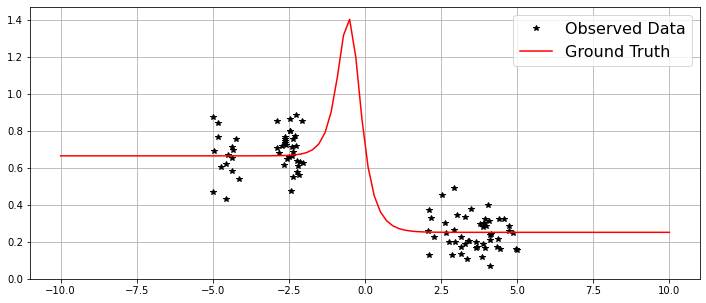

In [223]:
fs=16
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth'], fontsize = fs)
plt.grid()
plt.show()

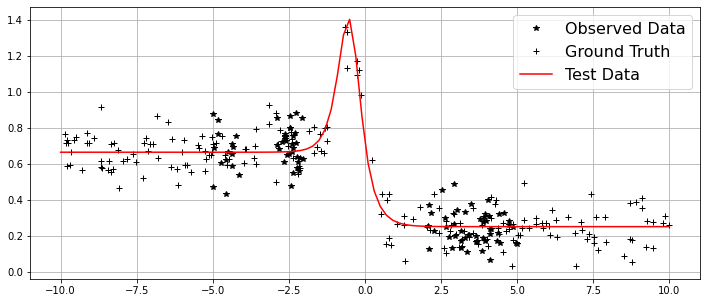

In [224]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(x_test,y_test, 'k+')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth', 'Test Data'], fontsize = 16)
plt.grid()
plt.show()

In [225]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x.view(-1, 1)))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_nodes=num_nodes)

# MF-VI Approx

In [226]:
from models.BNNs.SimpleBBPBNN import SimpleBBPBNN, train_bnn
from models.BNNs.pyroBNN_local_reparam import BayesianNeuralNetwork
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro
import pyro.distributions as dist

In [231]:
model = BayesianNeuralNetwork(prior_var=1./alpha, likelihood_var=1./beta * ELBO_BETA, hidden_nodes=num_nodes)
guide = AutoDiagonalNormal(model)

from pyro.infer import SVI, TraceMeanField_ELBO

adam = pyro.optim.Adamax({"lr": 0.001})
svi = SVI(model, guide, adam, loss=TraceMeanField_ELBO())

num_iterations = 10000
pyro.clear_param_store()
for j in trange(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

guide.requires_grad_(False)

params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

  0%|          | 0/10000 [00:00<?, ?it/s]

[iteration 0001] loss: 2422.2715
[iteration 0101] loss: 2826.5144
[iteration 0201] loss: 963.7600
[iteration 0301] loss: 1072.3569
[iteration 0401] loss: 815.7240
[iteration 0501] loss: 264.7054
[iteration 0601] loss: 85.0102
[iteration 0701] loss: 187.0661
[iteration 0801] loss: 101.7010
[iteration 0901] loss: 532.4513
[iteration 1001] loss: 101.4880
[iteration 1101] loss: 122.5987
[iteration 1201] loss: 73.4831
[iteration 1301] loss: 75.4858
[iteration 1401] loss: 183.9530
[iteration 1501] loss: 72.9076
[iteration 1601] loss: 222.9675
[iteration 1701] loss: 84.0096
[iteration 1801] loss: 147.9889
[iteration 1901] loss: 255.0364
[iteration 2001] loss: 132.4257
[iteration 2101] loss: 133.1144
[iteration 2201] loss: 99.4079
[iteration 2301] loss: 306.2169
[iteration 2401] loss: 269.3106
[iteration 2501] loss: 188.9329
[iteration 2601] loss: 203.8043
[iteration 2701] loss: 183.2766
[iteration 2801] loss: 76.8280
[iteration 2901] loss: 113.9883
[iteration 3001] loss: 111.1864
[iteration 3

In [232]:
model_loss = 'regression'

# Effect of tau
tau = alpha # Prior Precision
tau_out = beta # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

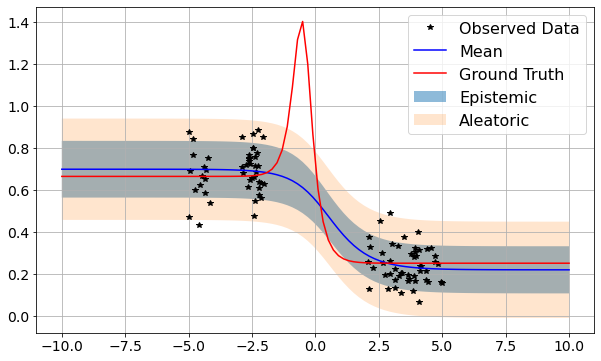

In [233]:
mean, stds = params

variational_posterior = dist.MultivariateNormal(loc=mean, covariance_matrix=torch.diag(stds ** 2))

variational_samples = variational_posterior.sample((1000,))
pred_list_var_exact, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=variational_samples,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_exact)

In [234]:
prior = D.MultivariateNormal(loc=torch.zeros_like(mean), covariance_matrix = 1./alpha * torch.eye(mean.shape[-1]))
D.kl_divergence(variational_posterior, prior)

tensor(30.1013)

# Compress some weights with variational scheme

In [196]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from tqdm.notebook import trange

coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler
omega = 5

In [197]:
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

initial_seed = 0
beamwidth = 1
epsilon = 0.



compute_params_enc =  encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)

n_auxiliaries = compute_params_enc.n_auxiliary
kl_q_p = compute_params_enc.total_kl
var_opt = VariationalOptimiser(compute_params_enc.target, omega, n_auxiliaries, kl_q_p, n_trajectories=16, total_var=1./alpha)
aux_vars = var_opt.run_optimiser(epochs=5000, lr=1e-1)

The mean loss is 20.59708. The mean KL is: 4.67390:   4%|▎         | 182/5000 [02:06<55:59,  1.43it/s] 


KeyboardInterrupt: 

# If have dist objects can load in and compress

In [ ]:
#ELBO_BETA = .0075
initial_seed = 0

In [ ]:
# variational_posterior = pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_post_beta_{ELBO_BETA}.pkl', 'rb'))
# aux_vars = pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_optimised_vars_beta_{ELBO_BETA}.pkl', 'rb'))
# kl_q_p = pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{ELBO_BETA}.pkl', 'rb'))
# variational_samples = pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_exact_beta_{ELBO_BETA}.pkl', 'rb'))

In [ ]:
kl_q_p

In [ ]:
initial_seed = initial_seed
beamwidth = 1
epsilon = 0.

compressed_weights_low_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_low_eps.append(w[0])

In [ ]:
pred_list_var_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_var_low_eps)

In [ ]:
initial_seed = initial_seed
beamwidth = 1
epsilon = 0.1

compressed_weights_var_med_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_med_eps.append(w[0])

In [ ]:
pred_list_var_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_var_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_med_eps)

In [ ]:
initial_seed = initial_seed
beamwidth = 1
epsilon = 0.2

compressed_weights_var_high_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_high_eps.append(w[0])

In [ ]:
pred_list_var_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_var_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_high_eps)

In [ ]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [ ]:
compute_gmm_lp(variational_samples, x_test, y_test)

In [ ]:
compute_gmm_lp(variational_samples, x_data, y_data)

In [ ]:
compute_gmm_lp(compressed_weights_low_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_var_med_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_var_high_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_var_high_eps, x_data, y_data)

In [ ]:
# dump the important stuff
import pickle as pkl
pkl.dump(variational_posterior, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_post_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(aux_vars, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_optimised_vars_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(variational_samples, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0_new.pkl', 'wb'))
pkl.dump(compressed_weights_var_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.1_new.pkl', 'wb'))
pkl.dump(compressed_weights_var_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.2_new.pkl', 'wb'))